In [2]:
from src.utils import get_spark_session

In [3]:
spark = get_spark_session()

:: loading settings :: url = jar:file:/Users/cristian.bitica/Projects/energy_code_challenge/venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/cristian.bitica/.ivy2/cache
The jars for the packages stored in: /Users/cristian.bitica/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ee364fcb-e055-4091-b6a2-2804e624aaf9;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.2.1 in spark-list
	found io.delta#delta-storage;3.2.1 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 98ms :: artifacts dl 2ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.2.1 from spark-list in [default]
	io.delta#delta-storage;3.2.1 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      d

In [2]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
import numpy as np

In [3]:
raw_data_df = spark.read.load(path="../input_data/*.csv", header=True, format='csv', inferSchema=True)

In [4]:
raw_data_df.summary().show()

24/12/06 10:03:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------------+
|summary|       turbine_id|        wind_speed|    wind_direction|      power_output|
+-------+-----------------+------------------+------------------+------------------+
|  count|            11160|             11160|             11160|             11160|
|   mean|              8.0| 12.00272401433692|179.90394265232976| 3.001926523297493|
| stddev|4.320687382459022|1.7353660714427142|103.35351302055334|0.8698311327250573|
|    min|                1|               9.0|                 0|               1.5|
|    25%|                4|              10.5|                91|               2.2|
|    50%|                8|              12.0|               180|               3.0|
|    75%|               12|              13.5|               269|               3.8|
|    max|               15|              15.0|               359|               4.5|
+-------+-----------------+------------------+------------------+

In [5]:
# hourly measurements for each turbine
hourly_measurements_df = (raw_data_df.groupBy(F.to_date('timestamp').alias('day'), 'turbine_id')
    .agg(
        F.count('timestamp').alias('timestamp_count'),
        F.count('wind_speed').alias('wind_speed_count'),
        F.count('wind_direction').alias('wind_direction_count'),
        F.count('power_output').alias('power_output_count'))
    .orderBy('day', 'turbine_id'))

In [6]:
hourly_measurements_df.filter('power_output_count > 24').show()

+---+----------+---------------+----------------+--------------------+------------------+
|day|turbine_id|timestamp_count|wind_speed_count|wind_direction_count|power_output_count|
+---+----------+---------------+----------------+--------------------+------------------+
+---+----------+---------------+----------------+--------------------+------------------+



In [16]:
raw_data_df.groupBy('turbine_id').agg(F.max('timestamp')).show()

+----------+-------------------+
|turbine_id|     max(timestamp)|
+----------+-------------------+
|        12|2022-03-31 23:00:00|
|        13|2022-03-31 23:00:00|
|        15|2022-03-31 23:00:00|
|        11|2022-03-31 23:00:00|
|        14|2022-03-31 23:00:00|
|         6|2022-03-31 23:00:00|
|         9|2022-03-31 23:00:00|
|         8|2022-03-31 23:00:00|
|         7|2022-03-31 23:00:00|
|        10|2022-03-31 23:00:00|
|         1|2022-03-31 23:00:00|
|         3|2022-03-31 23:00:00|
|         5|2022-03-31 23:00:00|
|         4|2022-03-31 23:00:00|
|         2|2022-03-31 23:00:00|
+----------+-------------------+



In [8]:
raw_data_df.filter('wind_direction is null').count()

0

In [9]:

raw_data_df.filter('power_output is null').count()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/cristian.bitica/Projects/energy_code_challenge/venv/lib/python3.11/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cristian.bitica/Projects/energy_code_challenge/venv/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cristian.bitica/Projects/energy_code_challenge/venv/lib/python3.11/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


#
# A fatal error has been detected by the Java Runtime Environment:
#
#  SIGSEGV (0xb) at pc=0x0000000105aa511c, pid=33273, tid=68611
#
# JRE version: OpenJDK Runtime Environment Homebrew (11.0.25) (build 11.0.25+0)
# Java VM: OpenJDK 64-Bit Server VM Homebrew (11.0.25+0, mixed mode, tiered, compressed oops, g1 gc, bsd-aarch64)
# Problematic frame:
# V  [libjvm.dylib+0x69511c]  ObjectSynchronizer::inflate(Thread*, oopDesc*, ObjectSynchronizer::InflateCause)+0x18c
#
# No core dump will be written. Core dumps have been disabled. To enable core dumping, try "ulimit -c unlimited" before starting Java again
#
# An error report file with more information is saved as:
# /Users/cristian.bitica/Projects/energy_code_challenge/src/hs_err_pid33273.log
#
# If you would like to submit a bug report, please visit:
#   https://github.com/Homebrew/homebrew-core/issues
#


Py4JError: An error occurred while calling o72.count

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/cristian.bitica/Projects/energy_code_challenge/venv/lib/python3.11/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cristian.bitica/Projects/energy_code_challenge/venv/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cristian.bitica/Projects/energy_code_challenge/venv/lib/python3.11/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [18]:
turbine_group_wdw = Window.partitionBy('turbine_id')
raw_data_mean_df = raw_data_df.select(
    "*",
    F.mean('wind_speed').over(turbine_group_wdw).alias('wind_speed_mean'),
    F.mean('wind_direction').over(turbine_group_wdw).alias('wind_direction_mean'),
    F.mean('power_output').over(turbine_group_wdw).alias('power_output_mean'),
    F.stddev('wind_speed').over(turbine_group_wdw).alias('wind_speed_stddev'),
    F.stddev('wind_direction').over(turbine_group_wdw).alias('wind_direction_stddev'),
    F.stddev('power_output').over(turbine_group_wdw).alias('power_output_stddev')
    )

In [19]:
raw_data_mean_df.show()

+-------------------+----------+----------+--------------+------------+------------------+-------------------+-----------------+-----------------+---------------------+-------------------+
|          timestamp|turbine_id|wind_speed|wind_direction|power_output|   wind_speed_mean|wind_direction_mean|power_output_mean|wind_speed_stddev|wind_direction_stddev|power_output_stddev|
+-------------------+----------+----------+--------------+------------+------------------+-------------------+-----------------+-----------------+---------------------+-------------------+
|2022-03-01 00:00:00|         1|      11.8|           169|         2.7|11.903091397849469|  181.1034946236559|3.016397849462364|1.772210673892375|   105.41646582186027| 0.8572389449056392|
|2022-03-01 01:00:00|         1|      11.6|           152|         4.4|11.903091397849469|  181.1034946236559|3.016397849462364|1.772210673892375|   105.41646582186027| 0.8572389449056392|
|2022-03-01 02:00:00|         1|      13.8|            

In [20]:
raw_data_z_score_df = raw_data_mean_df.select(
    "*",
    F.abs((F.col('wind_speed') - F.col('wind_speed_mean')) / F.col('wind_speed_stddev')).alias('wind_speed_z_score'),
    F.abs((F.col('wind_direction') - F.col('wind_direction_mean')) / F.col('wind_direction_stddev')).alias('wind_direction_z_score'),
    F.abs((F.col('power_output') - F.col('power_output_mean')) / F.col('power_output_stddev')).alias('power_output_z_score'),
    (F.col('wind_speed_mean') - (F.lit(2) * F.col('wind_speed_stddev'))).alias('wind_speed_2_stddev_low'),
    (F.col('wind_speed_mean') + (F.lit(2) * F.col('wind_speed_stddev'))).alias('wind_speed_2_stddev_high'),
    (F.col('wind_direction_mean') - (F.lit(2) * F.col('wind_direction_stddev'))).alias('wind_direction_2_stddev_low'),
    (F.col('wind_direction_mean') + (F.lit(2) * F.col('wind_direction_stddev'))).alias('wind_direction_2_stddev_high'),
    (F.col('power_output_mean') - (F.lit(2) * F.col('power_output_stddev'))).alias('power_output_2_stddev_low'),
    (F.col('power_output_mean') + (F.lit(2) * F.col('power_output_stddev'))).alias('power_output_2_stddev_high'),
)

In [21]:
raw_data_z_score_df.filter("wind_speed_z_score > 3 or wind_direction_z_score > 3 or power_output_z_score > 3").show()

+---------+----------+----------+--------------+------------+---------------+-------------------+-----------------+-----------------+---------------------+-------------------+------------------+----------------------+--------------------+-----------------------+------------------------+---------------------------+----------------------------+-------------------------+--------------------------+
|timestamp|turbine_id|wind_speed|wind_direction|power_output|wind_speed_mean|wind_direction_mean|power_output_mean|wind_speed_stddev|wind_direction_stddev|power_output_stddev|wind_speed_z_score|wind_direction_z_score|power_output_z_score|wind_speed_2_stddev_low|wind_speed_2_stddev_high|wind_direction_2_stddev_low|wind_direction_2_stddev_high|power_output_2_stddev_low|power_output_2_stddev_high|
+---------+----------+----------+--------------+------------+---------------+-------------------+-----------------+-----------------+---------------------+-------------------+------------------+----------

In [22]:
raw_data_z_score_df.filter("(power_output > power_output_2_stddev_high or power_output < power_output_2_stddev_low)").show()

+---------+----------+----------+--------------+------------+---------------+-------------------+-----------------+-----------------+---------------------+-------------------+------------------+----------------------+--------------------+-----------------------+------------------------+---------------------------+----------------------------+-------------------------+--------------------------+
|timestamp|turbine_id|wind_speed|wind_direction|power_output|wind_speed_mean|wind_direction_mean|power_output_mean|wind_speed_stddev|wind_direction_stddev|power_output_stddev|wind_speed_z_score|wind_direction_z_score|power_output_z_score|wind_speed_2_stddev_low|wind_speed_2_stddev_high|wind_direction_2_stddev_low|wind_direction_2_stddev_high|power_output_2_stddev_low|power_output_2_stddev_high|
+---------+----------+----------+--------------+------------+---------------+-------------------+-----------------+-----------------+---------------------+-------------------+------------------+----------

24/12/06 11:18:00 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 125560 ms exceeds timeout 120000 ms
24/12/06 11:18:00 WARN SparkContext: Killing executors is not supported by current scheduler.
24/12/06 11:18:09 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [4]:

wdw = Window.partitionBy(F.to_date("timestamp"))
raw_pandas_df = raw_data_df.select(
    "*",
    F.mean('wind_speed').over(wdw).alias('wind_speed_mean'),
    F.mean('wind_direction').over(wdw).alias('wind_direction_mean'),
    F.mean('power_output').over(wdw).alias('power_output_mean'),
    F.stddev('power_output').over(wdw).alias('power_output_stddev')
    ).toPandas()

In [12]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [13]:
outliers = find_outliers_IQR(raw_pandas_df["wind_direction"])

print("number of outliers: " + str(len(outliers)))

print("max outlier value: " + str(outliers.max()))

print("min outlier value: " + str(outliers.min()))

outliers

number of outliers: 0
max outlier value: nan
min outlier value: nan


Series([], Name: wind_direction, dtype: int32)

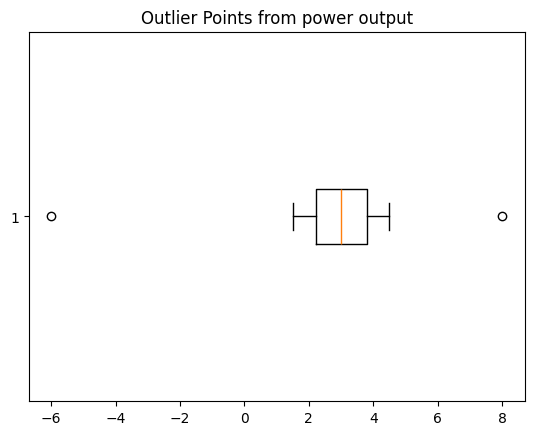

In [11]:
outliers_test = np.append(raw_pandas_df['power_output'], [-6, 8])
plt.boxplot(outliers_test, vert=False)
plt.title('Outlier Points from power output')
plt.show()

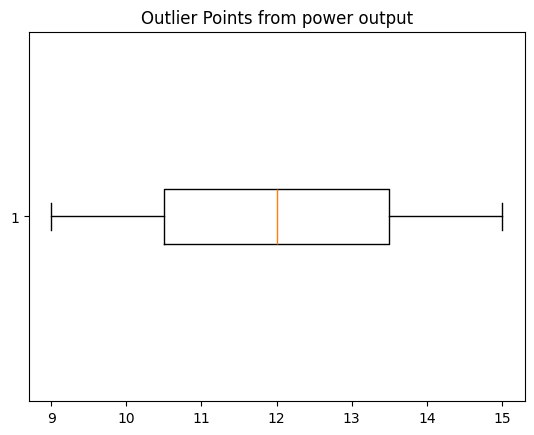

In [ ]:
plt.boxplot(raw_pandas_df['wind_speed'], vert=False)
plt.title('Outlier Points from power output')
plt.show()

In [ ]:
plt.scatter(raw_pandas_df["timestamp"], raw_pandas_df["wind_speed"], color='blue', marker='o', label='Wind speed over time')
plt.title("Wind speed over time")
plt.xlabel("timestamp")
plt.ylabel("wind_speed")
plt.grid(True, linestyle='--', alpha=0.6)
wind_speed_mean = np.mean(raw_pandas_df['wind_speed'])
plt.plot(wind_speed_mean, color='red', linestyle='--')
plt.legend()
plt.show()

In [ ]:
plt.scatter(raw_pandas_df["timestamp"], raw_pandas_df["wind_direction"], color='blue', marker='o', label='Wind direction over time')
plt.title("Wind direction over time")
plt.xlabel("timestamp")
plt.ylabel("wind_direction")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()